In [1]:
import torch
import numpy as np
import pickle
import copy
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_data():
    X_train = None
    Y_train = None
    for i in range(1, 6):
        pickleFile = unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_train) is np.ndarray:
            X_train = np.concatenate((X_train, dataX))
            Y_train = np.concatenate((Y_train, dataY))
        else:
            X_train = dataX
            Y_train = dataY

    Y_train = Y_train.reshape(Y_train.shape[0], 1)

    return X_train.T, Y_train.T

def load_test_data():
    X_test = None
    Y_test = None
    pickleFile = unpickle('cifar-10-batches-py/test_batch')
    dataX = pickleFile[b'data']
    dataY = pickleFile[b'labels']
    if type(X_test) is np.ndarray:
        X_test = np.concatenate((X_test, dataX))
        Y_test = np.concatenate((Y_test, dataY))
    else:
        X_test = np.array(dataX)
        Y_test = np.array(dataY)

    Y_test = Y_test.reshape(Y_test.shape[0], 1)

    return X_test.T, Y_test.T

def train_test_split(X_train, Y_train):
    msk = np.random.rand(Y_train.shape[1]) < 0.8
    X_Train = X_train[:,msk]  
    X_val = X_train[:,~msk]
    Y_Train = Y_train[:,msk]  
    Y_val = Y_train[:,~msk]

    return X_Train, Y_Train, X_val, Y_val

def get_batch1(X, Y, batch_size):
    n_batches = Y.shape[1]/batch_size
    idx = np.arange(Y.shape[1])
    np.random.shuffle(idx)
    mini = np.array_split(idx, n_batches)

    return mini

def get_batch(X, Y, batch_size):
    n_batches = int(Y.shape[1]/batch_size)
    idx = np.arange(Y.shape[1])
    np.random.shuffle(idx)
    
    ret = []
    for i in range(0,int(len(idx)/batch_size)):
        chunk = idx[i*batch_size:(i+1)*batch_size]
        ret.append(chunk)
    mini = ret
    
    return mini

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 256, 5)
        self.fc1 = nn.Linear(256 * 5 * 5, 400)
        self.fc2 = nn.Linear(400, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 256 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
X_train,Y_train = load_train_data()
X_test, Y_test = load_test_data()
X_Train, Y_Train, X_Val, Y_Val = train_test_split(X_train,Y_train)

minn = np.min(X_Train, axis=1,keepdims=True)
maxx = np.max(X_Train, axis=1,keepdims=True)
X_Train= (X_Train - minn)/(maxx-minn)
X_Val= (X_Val - minn)/(maxx-minn)
X_Test= (X_test - minn)/(maxx-minn)

net = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

def test_acc():
    correct = 0
    total = 0
    idx = get_batch(X_Test, Y_test, batch_size_len)

    for idx_list in idx:
        x_batch_test = [X_Test.T[index] for index in idx_list]
        y_batch_test = [Y_test.T[index] for index in idx_list]
        x_batch_test = np.asarray(x_batch_test)
        y_batch_test1 = np.asarray(y_batch_test)
        y_batch_onehot_test = get_one_hot(y_batch_test1,10)
        label_tensor_test = torch.from_numpy(y_batch_onehot_test)
        test_labels = Variable(label_tensor_test.cuda()).long()
        true_labels = torch.max(test_labels,1)[1]
        x_batch_test = x_batch_test.reshape(x_batch_test.shape[0],3,32,32)    
        input_tensor_test = torch.from_numpy(x_batch_test)
        images = Variable(input_tensor_test.cuda()).float()
        outputs = net(images)
        ##### loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == true_labels.data.long()).sum()
    
    return (100 * correct / total)

def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]


Start
Epoch 1 Count: 300 loss: 4.507030348777771 	 198 loss_val: 7.671198856830597 Test: 30.45
Epoch 2 Count: 300 loss: 3.755819387435913 	 198 loss_val: 6.819848694801331 Test: 39.58
Epoch 3 Count: 300 loss: 3.3833657693862915 	 198 loss_val: 6.49112389087677 Test: 42.07
Epoch 4 Count: 300 loss: 3.083226318359375 	 198 loss_val: 5.811731126308441 Test: 46.87
Epoch 5 Count: 300 loss: 2.8859377837181093 	 198 loss_val: 5.430765686035156 Test: 51.32
Epoch 6 Count: 300 loss: 2.73954252243042 	 198 loss_val: 5.44059867143631 Test: 51.21
Epoch 7 Count: 300 loss: 2.6322851729393006 	 198 loss_val: 5.134600827693939 Test: 53.13
Epoch 8 Count: 300 loss: 2.480918370485306 	 198 loss_val: 4.987261694669724 Test: 55.79
Epoch 9 Count: 300 loss: 2.432635027170181 	 198 loss_val: 4.800387369394302 Test: 57.42
Epoch 10 Count: 300 loss: 2.2937481200695036 	 198 loss_val: 4.5661030662059785 Test: 59.36
Epoch 11 Count: 300 loss: 2.1649432194232943 	 198 loss_val: 4.509821915626526 Test: 60.37
Epoch 12 C

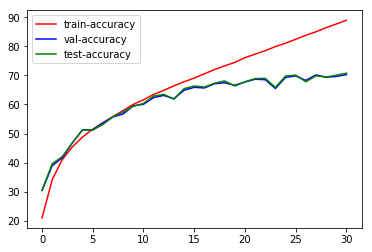

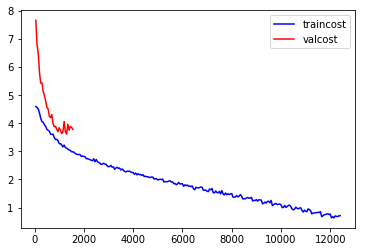

In [4]:
trainacc=[]
valacc=[]
testacc = []
traincost = []
valcost = []
epoch_count = 200
num = epoch_count
batch_size_len = 50 

train = ""
print("Start", flush=True)
for epoch in range(num):  # loop over the dataset multiple times
    running_loss = 0.0
    running_loss_val = 0.0
    train_accuracy = 0.0
    val_accuracy = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    #print(epoch, flush=True)
    abcd_train = get_batch(X_Train, Y_Train,batch_size_len)
    for i, idx in enumerate(abcd_train, 0):
        # get the inputs
        x_batch = [X_Train.T[index] for index in idx]
        y_batch = [Y_Train.T[index] for index in idx]
        x_batch = np.asarray(x_batch)
        y_batch = np.asarray(y_batch)
        y_batch_onehot = get_one_hot(y_batch,10)
        x_batch = x_batch.reshape(x_batch.shape[0],3,32,32)
        input_tensor = torch.from_numpy(x_batch)
        label_tensor = torch.from_numpy(y_batch_onehot)
        inputs = Variable(input_tensor.cuda()).float()
        labels = Variable(label_tensor.cuda()).long()
        true_labels = torch.max(labels,1)[1]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 100 == 99:    # print every 2000 mini-batches
            if(i+1 == 300):
                #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100), flush=True)
                #train = train + str(epoch + 1) + ", " + str(i + 1) + ", loss=" + str(running_loss / 100) + "; "
                print("Epoch", epoch + 1, "Count:", i + 1, "loss:", running_loss/(batch_size_len*1.0), end=' ')
            traincost.append(running_loss / (batch_size_len*1.0))
            running_loss = 0.0
            
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == true_labels.data.long()).sum()
    train_accuracy = 100 * correct_train / (total_train + 0.0001)
        
    abcd = get_batch(X_Val, Y_Val,batch_size_len)
#     for l in abcd:
#         print(len(l), end=' ')
#     print("")
    for i, idx in enumerate(abcd, 0):
        # get the inputs
        x_batch_val = [X_Val.T[index] for index in idx]
        y_batch_val = [Y_Val.T[index] for index in idx]
        x_batch_val = np.asarray(x_batch_val)
        y_batch_val = np.asarray(y_batch_val)
        y_batch_onehot_val = get_one_hot(y_batch_val,10)
        x_batch_val = x_batch_val.reshape(x_batch_val.shape[0],3,32,32)
        input_tensor_val = torch.from_numpy(x_batch_val)
        label_tensor_val = torch.from_numpy(y_batch_onehot_val)
        inputs_val = Variable(input_tensor_val.cuda()).float()
        labels_val = Variable(label_tensor_val.cuda()).long()
        true_labels_val = torch.max(labels_val,1)[1]
        optimizer.zero_grad()
        outputs_val = net(inputs_val)
        loss_val = criterion(outputs_val, torch.max(labels_val, 1)[1])
        running_loss_val += loss_val.data[0]
#         if(i > 97):
#             print("Hello", i)
        if i == len(abcd) - 1:    # print every 2000 mini-batches
            test_accuracy = test_acc()
            print("\t", i, "loss_val:", running_loss_val/(batch_size_len*1.0), "Test:", test_accuracy)
            valcost.append(running_loss_val/(batch_size_len*1.0))
            running_loss_val = 0.0
        
        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == true_labels_val.data.long()).sum()
    val_accuracy = 100 * correct_val / total_val
    trainacc.append(train_accuracy)
    valacc.append(val_accuracy)
    testacc.append(test_accuracy)
    if(val_accuracy>=70.2):
        print("Target Val Accuracy reached. Breaking", flush=True)
        break
    
print('Finished Training', flush=True)
print('Training Accuracy ',trainacc, flush=True)
print('validation Accuracy',valacc, flush=True)
print("Test:", test_acc(), flush=True)

plt.figure()
plt.plot(trainacc, 'r', label ='train-accuracy')
plt.plot(valacc, 'b', label = 'val-accuracy')
plt.plot(testacc, 'g', label = 'test-accuracy')
plt.legend()
plt.savefig("test.png")


x_t = []
x_v = []

for i in range(len(traincost)):
    x_t.append((i+1)*batch_size_len)

for i in range(len(valcost)):
    x_v.append((i+1)*batch_size_len)

plt.figure()
plt.plot(x_t,traincost, 'b', label = 'traincost')
plt.plot(x_v,valcost, 'r', label = 'valcost')
plt.legend()
plt.savefig("test1.png")

In [5]:
print(valacc)
print(testacc)

[30.371859296482413, 38.93467336683417, 41.64824120603015, 46.8643216080402, 51.23618090452261, 51.21608040201005, 53.65829145728643, 55.73869346733668, 56.733668341708544, 59.5678391959799, 60.06030150753769, 62.391959798994975, 63.12562814070352, 61.969849246231156, 64.91457286432161, 65.90954773869346, 65.68844221105527, 67.15577889447236, 67.47738693467336, 66.62311557788945, 67.7286432160804, 68.69346733668341, 68.5427135678392, 65.50753768844221, 69.33668341708542, 69.82914572864321, 68.30150753768844, 70.19095477386935, 69.38693467336684, 69.64824120603015, 70.2713567839196]
[30.45, 39.58, 42.07, 46.87, 51.32, 51.21, 53.13, 55.79, 57.42, 59.36, 60.37, 62.89, 63.48, 61.85, 65.45, 66.39, 65.99, 67.32, 68.12, 66.36, 67.82, 68.91, 69.0, 65.91, 69.77, 70.11, 67.84, 69.86, 69.46, 70.08, 70.75]
